## FBA simulation
Simulating the FBA part of the diauxic growth model with `cobrapy` to check that the FBA part is working.
This requires
* `cobrapy >= 0.6.0a3`

In [1]:
from __future__ import print_function, absolute_import

import pandas as pd
import cobra
from matplotlib import pyplot as plt

from sbmlutils import fbc
from sbmlutils.dfba.analysis import set_matplotlib_parameters
from sbmlutils.dfba.diauxic_growth import model_factory

set_matplotlib_parameters()

/usr/local/lib/python2.7/dist-packages/optlang/gurobi_interface.py:26: UserWarning: Be careful! The GUROBI interface is still under construction ...
  warn("Be careful! The GUROBI interface is still under construction ...")


In [2]:
# load model
sbml_path = './results/v{}/diauxic_fba.xml'.format(model_factory.version)
print(sbml_path)
mfba = cobra.io.read_sbml_model(sbml_path)
cobra.io.sbml3.validate_sbml_model(sbml_path)

./results/v9/diauxic_fba.xml


(<Model diauxic_fba at 0x7f7301c21c50>,
 {'SBML errors': [], 'other': [], 'validator': [], 'warnings': []})

In [3]:
# objective function & boundaries
# pprint(mfba.objective)
fbc.cobra_reaction_info(mfba)

,lb,ub,reversibility,boundary,objective_coefficient,forward_variable,reverse_variable
v1,0,1000,False,False,1,0.0 <= v1 <= 1000.0,0 <= v1_reverse_6654c <= 0
v2,0,1000,False,False,1,0.0 <= v2 <= 1000.0,0 <= v2_reverse_1b267 <= 0
v3,0,1000,False,False,1,0.0 <= v3 <= 1000.0,0 <= v3_reverse_43a03 <= 0
v4,0,1000,False,False,1,0.0 <= v4 <= 1000.0,0 <= v4_reverse_5ed3a <= 0
EX_O2,-1000,1000,True,True,0,0 <= EX_O2 <= 1000.0,0 <= EX_O2_reverse_23804 <= 1000.0
EX_Glcxt,-1000,1000,True,True,0,0 <= EX_Glcxt <= 1000.0,0 <= EX_Glcxt_reverse_34a63 <= 1000.0
EX_Ac,-1000,1000,True,True,0,0 <= EX_Ac <= 1000.0,0 <= EX_Ac_reverse_3765e <= 1000.0
EX_X,-1000,1000,True,True,0,0 <= EX_X <= 1000.0,0 <= EX_X_reverse_ff29b <= 1000.0


In [4]:
# lookat the v4 property


# simulate
# s = mfba.optimize()
s = mfba.optimize(objective_sense="maximize")
print(s.status)
mfba.summary()

optimal
IN FLUXES     OUT FLUXES    OBJECTIVES
------------  ------------  ------------
Glcxt  1e+03  Ac  169       v1   0
O2     1e+03  X    91.3     v2  77.4
                            v3   0
                            v4  13.9


In [5]:
# summary of solution
mfba.summary(fva=True)

IN FLUXES                      OUT FLUXES                  OBJECTIVES
-----------------------------  --------------------------  ------------
id       Flux  Range           id      Flux  Range         v1   0
-----  ------  --------------  ----  ------  ------------  v2  77.4
Glcxt   1e+03  [1e+03, 1e+03]  Ac     169    [169, 169]    v3   0
O2      1e+03  [1e+03, 1e+03]  X       91.3  [91.3, 91.3]  v4  13.9


In [6]:
# FVA
# running flux variability analysis with the model
fva_result = cobra.flux_analysis.flux_variability_analysis(mfba, mfba.reactions)
pd.DataFrame.from_dict(fva_result).T.round(5)

,EX_Ac,EX_Glcxt,EX_O2,EX_X,v1,v2,v3,v4
maximum,168.78619,-1000.0,-1000.0,91.32563,-0.0,77.39938,-0.0,13.92625
minimum,168.78619,-1000.0,-1000.0,91.32563,0.0,77.39938,0.0,13.92625


## Change the bounds

In [10]:
import numpy as np
import pandas as pd
glc_bounds = np.linspace(-1000, 0, 20)
results = []
for lb_glc in glc_bounds:
    mfba.reactions.EX_Glcxt.lower_bound = lb_glc
    s = mfba.optimize(objective_sense="maximize")
    fluxes = s.fluxes
    results.append(fluxes)
df = pd.DataFrame(results)
print(df)

           v1         v2   v3         v4        EX_O2     EX_Glcxt  \
0    0.000000  77.399381  0.0  13.926254 -1000.000000 -1000.000000   
1    0.000000  77.399381  0.0  11.189302 -1000.000000  -947.368421   
2    0.000000  77.399381  0.0   8.452350 -1000.000000  -894.736842   
3    0.000000  77.399381  0.0   5.715399 -1000.000000  -842.105263   
4    0.000000  77.399381  0.0   2.978447 -1000.000000  -789.473684   
5    0.000000  77.399381  0.0   0.241496 -1000.000000  -736.842105   
6    1.872546  72.326694  0.0   0.000000 -1000.000000  -684.210526   
7    3.926306  66.763102  0.0   0.000000 -1000.000000  -631.578947   
8    5.980066  61.199510  0.0   0.000000 -1000.000000  -578.947368   
9    8.033827  55.635919  0.0   0.000000 -1000.000000  -526.315789   
10  10.087587  50.072327  0.0   0.000000 -1000.000000  -473.684211   
11  12.141347  44.508735  0.0   0.000000 -1000.000000  -421.052632   
12  14.195107  38.945143  0.0   0.000000 -1000.000000  -368.421053   
13  16.248867  33.38

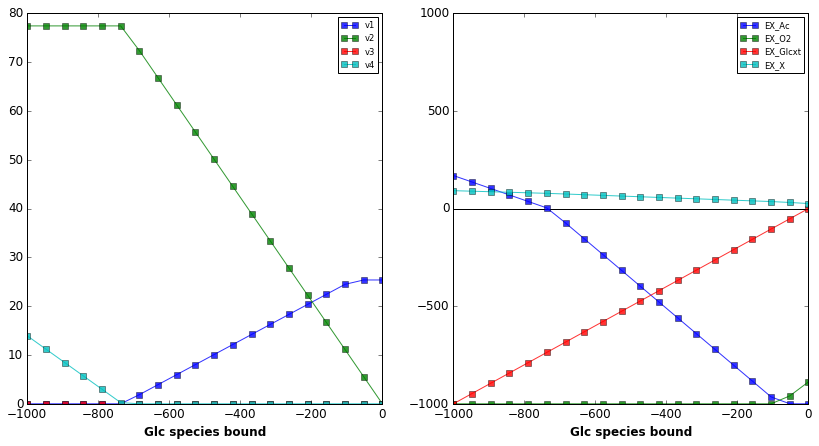

In [11]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(14, 7))

for vid in ['v1', 'v2', 'v3', 'v4']:
    ax1.plot(df.EX_Glcxt, df[vid], marker='s', alpha=0.8, label=vid)

ax2.plot([np.min(glc_bounds), np.max(glc_bounds)], [0, 0], color='k', linestyle='-', linewidth=1)
for vid in ['EX_Ac', 'EX_O2', 'EX_Glcxt', 'EX_X']:
    ax2.plot(df.EX_Glcxt, df[vid], marker='s', alpha=0.8, label=vid)
ax2.set_ylim(-1000, 1000)
    
for ax in [ax1, ax2]:
    ax.set_xlabel('Glc species bound')
    ax.legend()

plt.show()